In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

Exploratory Climate Analysis

In [11]:
end_date = engine.execute("select max(date) from Measurement").fetchall()
end_date

[('2017-08-23',)]

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
date_year_ago = dt.datetime(2017, 8, 23) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
prcp_results = session.query(Measurement.prcp, Measurement.date).\
    filter(Measurement.date >= date_year_ago).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns=["prcp","date"])
prcp_df = prcp_df.rename(columns={"prcp": "precipitation"})
prcp_df.set_index("date", inplace=True)
# Sort the dataframe by date
prcp_df.sort_values("date").dropna()
prcp_df.head()



,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


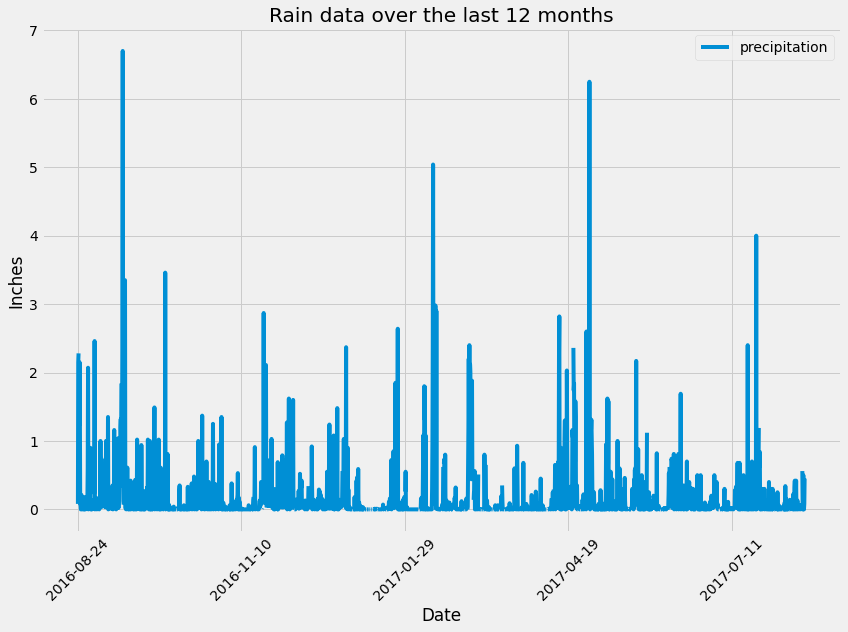

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(rot=45, figsize=(12,9))
plt.title("Rain data over the last 12 months")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig("Images/rain.png")
plt.show()

In [16]:
 # Use Pandas to calcualte the summary statistics for the precipitation data
 prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).scalar()
print(f"There are {station_count} stations")

There are 9 stations


In [18]:
 # What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
 # Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_id = "USC00519281"
low_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == station_id).scalar()
high_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == station_id).scalar()
ave_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_id).scalar()

print(f"The lowest temp was {low_temp}")
print(f"The hightest temp was {high_temp}")
print(f"The average temp was {round(ave_temp,2)}")

The lowest temp was 54.0
The hightest temp was 85.0
The average temp was 71.66


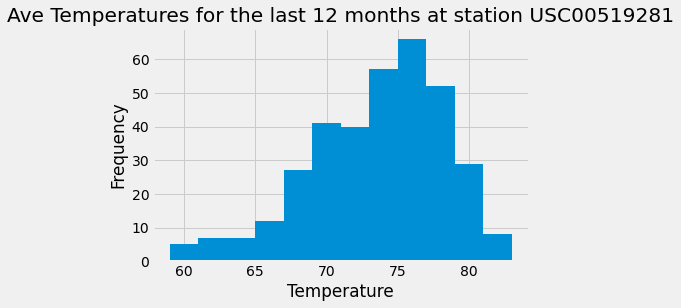

In [20]:
# Choose the station with the highest number of temperature observations.
max_tobs = station_activity[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_results = session.query(Measurement.tobs, Measurement.date).\
    filter(Measurement.date > date_year_ago).\
    filter(Measurement.station == station_id).\
    order_by(Measurement.date).all()

tobs_df = pd.DataFrame(tobs_results)
tobs_df = tobs_df.set_index("date").sort_index(ascending=True)
tobs_df["tobs"].hist(bins=12)
plt.title(f"Ave Temperatures for the last 12 months at station {station_id}")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.savefig("Images/temp.png")
plt.show()

Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-05-24', '2016-05-30'))

[(67.0, 74.92857142857143, 81.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
trip_start = "2015-05-24"
trip_end = "2015-05-30"

tmin, tave, tmax = calc_temps(trip_start, trip_end)[0]

print(f"Mininum temp for trip is {tmin}")
print(f"Average temp for trip is {tave}")
print(f"Maximum temp for trip is {tmax}")

Mininum temp for trip is 64.0
Average temp for trip is 71.3125
Maximum temp for trip is 78.0


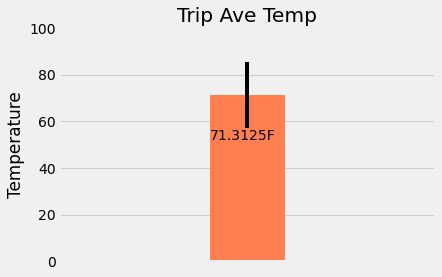

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = tmax - tmin 
xpos = 1

fig, ax = plt.subplots()
plt.bar(xpos, tave, yerr=error, width=0.2, color="coral")
plt.xticks([])
plt.xlim(0.5,1.5)
plt.ylim(0,100)
plt.tight_layout
plt.text(x=0.9, y=52, s=f"{tave}F")
plt.title("Trip Ave Temp")
plt.ylabel("Temperature")
plt.savefig("Images/Trip_ave_temp.png")
plt.show()

In [24]:
 # Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain = session.query(Station.station, Station.name, Station.latitude, 
            Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station, Measurement.date.between(trip_start, trip_end)).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

rain_df = pd.DataFrame(np.array(rain))
rain_df.rename(columns={0: "Station", 1: "Location", 2: "Latitude", 3: "Longitude",
                4: "Elevation", 5: "Rain"}, inplace=True)
rain_df


,Station,Location,Latitude,Longitude,Elevation,Rain
0,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6,1.46
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84888999999998,32.9,1.2
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0,0.89
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.8200000000000001
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,0.11
5,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,0.0
6,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6,0.0
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.3152,-157.9992,0.9,0.0


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
 # calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = dt.date(2016,5,24)
trip_end_date = dt.date(2016,5,30)
# Use the start and end date to create a range of dates
date_range = pd.date_range(trip_start_date, trip_end_date)
# Stip off the year and save a list of %m-%d strings
# dates = [func.strftime("%m-%d") for date in date_range]
dates = ["-".join(str(x).split(" ")[0].split("-")[1:3]) for x in date_range]


# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normal = [daily_normals(date)[0] for date in dates]
print(daily_normal)
# print([str(date) for date in date_range])


[(67.0, 73.94827586206897, 79.0), (68.0, 74.27586206896552, 79.0), (65.0, 74.03636363636363, 82.0), (65.0, 74.49090909090908, 80.0), (67.0, 74.27777777777777, 82.0), (64.0, 74.19607843137256, 80.0), (69.0, 74.33333333333333, 81.0)]


In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normal_df = pd.DataFrame(daily_normal, columns=["Min Temp", "Ave Temp", "Max Temp"],
        index=date_range)
daily_normal_df.index.name = "Date"
daily_normal_df

,Min Temp,Ave Temp,Max Temp
Date,,,
2016-05-24,67.0,73.948276,79.0
2016-05-25,68.0,74.275862,79.0
2016-05-26,65.0,74.036364,82.0
2016-05-27,65.0,74.490909,80.0
2016-05-28,67.0,74.277778,82.0
2016-05-29,64.0,74.196078,80.0
2016-05-30,69.0,74.333333,81.0


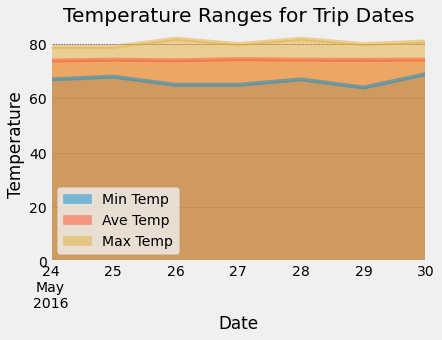

In [30]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normal_df.plot.area(stacked=False)
plt.ylabel("Temperature")
plt.grid(color="black", linestyle= "--", linewidth= 0.5)
plt.title("Temperature Ranges for Trip Dates")
plt.savefig("Images/Daily_Normals.png")
plt.show()

In [ ]:
session.close()